Imports

In [1]:
#Omid55
import requests
import pandas as pd
import pickle as pk
import csv
import time
import numpy as np
import random
from scipy.stats import pearsonr as corr

import seaborn as sns
import matplotlib.pylab as plt
% matplotlib inline

In [2]:
URL = {
    'BASE': 'https://{proxy}.api.pvp.net/api/lol/{region}/{rest}',
    'STATIC_BASE': 'https://global.api.pvp.net/api/lol/static-data/{region}/v1.2/{rest}',
    
    'MATCHLIST_URL': 'v2.2/matchlist/by-summoner/{summonerId}?seasons=SEASON{season}',
    'MATCH_URL': 'v2.2/match/{matchId}',
    'CHAMPION_URL': 'champion/{id}?champData=all',
    'SUMMONER_URL': 'v1.4/summoner/{summonerId}',
    #'SUMMONER_WINS_LOSSES_URL': 'v2.5/league/by-summoner/{summonerId}'  # NOT TRUE (VERY LARGE NUMBERS)
    'SUMMONER_WINS_LOSSES_PER_CHAMPION_URL': 'v1.3/stats/by-summoner/{summonerId}/ranked?season=SEASON{season}'
    
    # /api/lol/{region}/v1.3/stats/by-summoner/{summonerId}/ranked: this is for getting the experience 
    #  of player (summonerId) with different champions and also ALL EXPERIENCE one person has
    
    # /api/lol/{region}/v1.3/game/by-summoner/{summonerId}/recent: games that one summoner plays 
    #  with other people
}

REGIONS = {
    'north america': 'na',
    'europe west': 'euw'
}

In [3]:
class Match(object):
    
    def __init__(self):
        self.winners = []
        self.losers = []
        self.duration = -1
        

In [17]:
class RiotAPI(object):
    
    def __init__(self, api_key, region=REGIONS['north america']):
        self.api_key = api_key
        self.region = region
        self.champions = {}
#         self.champions_allinfo = {}
#         self.champions_allinfo_saved = False
        self.summoner_wins_losses = {}
        
    def _request(self, base, rest, params={}):
        args = {'api_key': self.api_key}
        args.update(params)
        response = requests.get(
            URL[base].format(
                rest=rest,
                proxy=self.region,
                region=self.region,
            ),
            params=args
        )
        #print(response.request.url)
        time.sleep(1.2)
        return response.json()
    
    def _base_request(self, rest, params={}):
        return self._request('BASE', rest, params)
        
    def _static_request(self, rest, params={}):
        return self._request('STATIC_BASE', rest, params)
    
    # functions
    def get_summoner_level(self, sid):
        rest = URL['SUMMONER_URL'].format(
            summonerId=sid
        )
        return self._base_request(rest)
    
    def _get_list_of_match_ids(self, sid, season):
        rest = URL['MATCHLIST_URL'].format(
            summonerId=sid,
            season=season
        )
        result = self._base_request(rest)
        if 'matches' in result:
            for match in result['matches']:
                yield match['matchId']
                
    def _get_match(self, mid):
        rest = URL['MATCH_URL'].format(
            matchId=mid
        )
        result = self._base_request(rest)
        return result
        
    def get_champion_all_info(self, championId):
        rest = URL['CHAMPION_URL'].format(
            id=championId
        )
        return self._static_request(rest)
    
#     def get_champion_index(self, championId):
#         if championId not in self.champions:
#             myid = len(self.champions)
#             self.champions_allinfo[myid] = self.get_champion_all_info(championId)
#             if not self.champions_allinfo_saved and len(self.champions_allinfo) == 132:
#                 with open('DATAChampionsAllInfo.pkl', 'wb') as output:
#                     pk.dump(self.champions_allinfo, output)
#                     self.champions_allinfo_saved = True
#             self.champions[championId] = myid
#         return self.champions[championId]
    
    def get_matches_champions_and_summonerIds_before_game(self, season, just_Ids=True):
        #for sid in range(1,1000000):    #for sid in range(1000000,5000000):
        with open('summonerId_list.pkl', 'rb') as f:
            all_summoners = pk.load(f)
        summoners = [ all_summoners[i] for i in sorted(random.sample(range(len(all_summoners)), 1000)) ]
        for sid in summoners:
            matchids = self._get_list_of_match_ids(sid, season)
            for matchid in matchids:
                match = self._get_match(matchid)
                if 'participants' in match:
                    losers = []
                    winners = []
                    winners_sid = []
                    losers_sid = []
                    
                    for member in match['participants']:
                        suId = [pi['player']['summonerId'] for pi in match['participantIdentities'] if pi['participantId']==member['participantId']][0]
                        if member['stats']['winner']:
                            winners_sid.append(suId)
                            
                            if just_Ids:
                                winners += [member['championId']]
                            else:
                                winners += (self.get_champion_capabilities(member['championId']))
                        else:
                            losers_sid.append(suId)
                            
                            if just_Ids:
                                losers += [member['championId']]
                            else:
                                losers += (self.get_champion_capabilities(member['championId']))
                    data = {'matchId': match['matchId'], 'duration': match['matchDuration'], 'champions': winners + losers, 'summoners': winners_sid + losers_sid}
                    yield data
                    
    # --------------------------------------------------------------------------------------
    def get_summoner_wins_losses(self, sid, season):
        key = str(sid)+','+str(season)
        if key not in self.summoner_wins_losses:
            res = {}
            rest = URL['SUMMONER_WINS_LOSSES_PER_CHAMPION_URL'].format(
                summonerId=sid,
                season=season
            )
            result = self._base_request(rest)
            if 'champions' in result:
                for ch in result['champions']:
                    if ch['id']:
                        res[ch['id']] = [ch['stats']['totalSessionsWon'], ch['stats']['totalSessionsLost']]
            self.summoner_wins_losses[key] = res
        return self.summoner_wins_losses[key]
        
    def get_win_stats(self, team_summoners, team_champs, season):
        game = []
        win_ratio = []
        same_champ_game = []
        same_champ_win_ratio = []
        for i in range(5):
            ch_history = self.get_summoner_wins_losses(team_summoners[i], season=season)
            if ch_history:
                if team_champs[i] in ch_history:
                    a = ch_history[team_champs[i]]
                    same_champ_game.append(a[0] + a[1])
                    same_champ_win_ratio.append(a[0]/float(a[0] + a[1]))
                a = np.sum(list(ch_history.values()), axis=0)
                game.append(a[0] + a[1])
                win_ratio.append(a[0]/float(a[0] + a[1]))
        if len(game) < 4:
            return []
        else:
            return [
                np.average(game),
                np.std(game),
                np.average(win_ratio),
                np.std(win_ratio),
                np.average(same_champ_game),
                np.std(same_champ_game),
                np.average(same_champ_win_ratio),
                np.std(same_champ_win_ratio)
                ]
    # --------------------------------------------------------------------------------------
    
    def get_matches_champions_and_summonerIds_before_game_for_those_summoners_have_similar_stats_2_seasons(self, season, just_Ids=True):
        with open('summonerId_list.pkl', 'rb') as f:
            all_summoners = pk.load(f)
        for sid in all_summoners:
        #for sid in range(1,1000000000):
            matchids = self._get_list_of_match_ids(sid, season)
            for matchid in matchids:
                nodata = 0
                match = self._get_match(matchid)
                if 'participants' in match:
                    losers = []
                    winners = []
                    winners_sid = []
                    losers_sid = []
                    
                    for member in match['participants']:
                        suId = [pi['player']['summonerId'] for pi in match['participantIdentities'] if pi['participantId']==member['participantId']][0]
                        if not self.does_she_have_similar_history_in_two_seasons(suId, season-1, season):
                            nodata += 1
                            if nodata >= 8:
                                break
                            
                        if member['stats']['winner']:
                            winners_sid.append(suId)

                            if just_Ids:
                                winners += [member['championId']]
                            else:
                                winners += (self.get_champion_capabilities(member['championId']))
                        else:
                            losers_sid.append(suId)

                            if just_Ids:
                                losers += [member['championId']]
                            else:
                                losers += (self.get_champion_capabilities(member['championId']))
                    if nodata >= 8:
                        continue
                    data = {'matchId': match['matchId'], 'duration': match['matchDuration'], 'champions': winners + losers, 'summoners': winners_sid + losers_sid}
                    yield data
                    
    def does_she_have_similar_history_in_two_seasons(self, sid, season1, season2):
        # conflict based
#         h1 = self.get_summoner_wins_losses(sid, season1)
#         h2 = self.get_summoner_wins_losses(sid, season2)
#         c1 = len(set(list(h1.keys()) + list(h1.keys())))
#         return c1 !=0 and len(list(set(h1.keys()) & set(h2.keys()))) / float(c1) >= 0.7

        # correlation based
        h1 = self.get_summoner_wins_losses(sid, season1)
        h2 = self.get_summoner_wins_losses(sid, season2)
        wr1 = []
        wr2 = []
        for k in list(set(h1.keys()) & set(h2.keys())):
            wr1.append(h1[k][0]/float(h1[k][0]+h1[k][1]))
            wr2.append(h2[k][0]/float(h2[k][0]+h2[k][1]))
        if len(wr1)<3 or len(wr2)<3:
            return False
        c = corr(wr1, wr2)
        return c[1]<1 and c[0]>0.3
        
        
with open('../MyKey4.key', 'r') as key_file:
    KEY = key_file.readline().strip()
api = RiotAPI(KEY)

# Run the script

In [18]:
LIMIT = 1400
dt = api.get_matches_champions_and_summonerIds_before_game_for_those_summoners_have_similar_stats_2_seasons(season=2016)

data = []
for d in dt:
    data.append(d)
    if not len(data) % 5:
        print(len(data))
    if len(data) > LIMIT:
        break
        

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800


ValueError: Expecting value: line 1 column 1 (char 0)

In [19]:
print(len(data), 'samples are saving...')
with open('ReallyGoodCorrSummonersDataChampionProficiencyPlaynet.pkl', 'wb') as dfile:
    pk.dump(data, dfile)
print('Done.')

804 samples are saving...
Done.


(array([   1.,    0.,    0.,    0.,    0.,  620.,  156.,    0.,   24.,    3.]),
 array([ 0. ,  0.6,  1.2,  1.8,  2.4,  3. ,  3.6,  4.2,  4.8,  5.4,  6. ]),
 <a list of 10 Patch objects>)

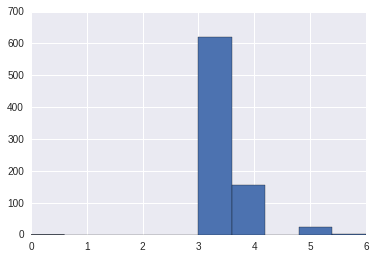

In [26]:
goods = []
for d in data:
    good = 0
    for i in range(10):
        if len(d['champions'])==10 and api.does_she_have_similar_history_in_two_seasons(d['summoners'][i], 2015, 2016):
            good += 1
    goods.append(good)
plt.hist(goods)

In [25]:
dt = []
#sampl_data = [data[i] for i in sorted(random.sample(range(len(data)), 1500))]
for d in data:
    if len(d['champions'])==10:
        winner = api.get_win_stats(d['summoners'][:5], d['champions'][:5], 2015)
        if not winner:
            continue
        loser = api.get_win_stats(d['summoners'][5:], d['champions'][5:], 2015)
        if not loser:
            continue
        dt.append(winner + loser)
        if len(dt) % 10 == 0:
            print(len(dt))
dataset = pd.DataFrame(data=dt, columns=['winner_avg_game_count', 'winner_std_game_count', 'winner_avg_win_ratio', 'winner_std_win_ratio', 'winner_avg_same_champion_game_count', 'winner_std_same_champion_game_count', 'winner_avg_same_champion_win_ratio', 'winner_std_same_champion_win_ratio', 'loser_avg_game_count', 'loser_std_game_count', 'loser_avg_win_ratio', 'loser_std_win_ratio', 'loser_avg_same_champion_game_count', 'loser_std_same_champion_game_count', 'loser_avg_same_champion_win_ratio', 'loser_std_same_champion_win_ratio'])

dataset.to_csv('ReallyGoodCorrStat2015_for_Classification2016_Dataset.csv')

/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700


# Filtering summoners using history of games in 2015 and 2016 stats

In [ ]:
def plot_distribution_of_correlation(summoner_ids):
    r = []
    p = []
    for sid in summoner_ids:
        h1 = api.get_summoner_wins_losses(sid, 2015)
        h2 = api.get_summoner_wins_losses(sid, 2016)
        wr1 = []
        wr2 = []
        for k in list(set(h1.keys()) & set(h2.keys())):
            wr1.append(h1[k][0]/float(h1[k][0]+h1[k][1]))
            wr2.append(h2[k][0]/float(h2[k][0]+h2[k][1]))
    #         wr1.append(h1[k][0]+h1[k][1])
    #         wr2.append(h2[k][0]+h2[k][1])
        c = corr(wr1, wr2)
        r.append(c[0])
        p.append(c[1])
    plt.hist(np.array(r)[np.where(np.array(p)<0.05)])

Selecting summoners based on 80% of conflicting champion choice

In [ ]:
with open('summonerId_list.pkl', 'rb') as dfile:
    summoners = pk.load(dfile)
good_sids = []
for sid in summoners:
    h1 = api.get_summoner_wins_losses(sid, 2015)
    h2 = api.get_summoner_wins_losses(sid, 2016)
    c1 = len(set(list(h1.keys()) + list(h1.keys())))
    if c1 !=0 and len(list(set(h1.keys()) & set(h2.keys()))) / c1 < 0.8:
        continue
    good_sids.append(sid)
print(len(good_sids))
plot_distribution_of_correlation(good_sids)

Selecting summoners based on positive (larger than 0.3) of 2015 and 2016 win ratio

In [ ]:
with open('summonerId_list.pkl', 'rb') as dfile:
    summoners = pk.load(dfile)
gggood_sids = []
for sid in summoners:
    h1 = api.get_summoner_wins_losses(sid, 2015)
    h2 = api.get_summoner_wins_losses(sid, 2016)
    wr1 = []
    wr2 = []
    for k in list(set(h1.keys()) & set(h2.keys())):
        wr1.append(h1[k][0]/float(h1[k][0]+h1[k][1]))
        wr2.append(h2[k][0]/float(h2[k][0]+h2[k][1]))
    if len(wr1)<3 or len(wr2)<3:
        continue
    c = corr(wr1, wr2)
    if c[1]<1 and c[0]>0.3:
        gggood_sids.append(sid)
print(len(gggood_sids))
plot_distribution_of_correlation(gggood_sids)